In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# Helper functions

These are borrowed from the `Convert.ipynb` file.

In [2]:
headings = ['Building Identifier',
            'Country',
             'City',
             'Quality / Stage of Data',
             'Construction Date',
             'Building Type',
             'Gross Floor Area']

In [3]:
df = pd.read_excel('../Dataset/dataset.xlsx',header=1,usecols='B:DWO')

In [4]:
mapper = pd.read_excel('../Conversion/Mapping material names_20210324.xlsx',header=2,usecols='B:U').replace(r'\n','', regex=True) 

In [5]:
name_conversion = pd.read_csv('name_conversion.csv')
building_name_conversion = pd.read_csv('building_type_name_conversion.csv')

In [6]:
building_name_map = {k['Building Code']:k['Building Type'] for _,k in building_name_conversion.iterrows()}

In [7]:
name_map = {k.Code:k.Category for _,k in name_conversion.iterrows()}

In [8]:
additional_categories_map = {v:k for k,v in {
    'Continuous Footings':'0CF',
    'Foundation Walls':'0FW',
    'Spread Footings':'0SF',
    'Column Piers':'0CP',
    'Columns Supporting Floors':'CSF',
    'Floor Girders and Beams':'FGB',
    'Floor Trusses':'0FT',
    'Floor Joists':'0FJ',
    'Columns Supporting Roofs':'CSR',
    'Roof Girders and Beams':'RGB',
    'Roof Trusses':'0RT',
    'Roof Joists':'0RJ',
    'Parking Bumpers':'0PB',
    'Precast Concrete Stair Treads':'PCS',
    'Roof Curbs':'0RC',
    'Exterior Wall Construction':'EWC',
    'Composite Decking':'CPD',
    'Cast-in-Place concrete':'CIC',
    'Floor Structural Frame':'FSF',
    'Associated Metal Fabrications':'AMF',
    'Floor Construction Supplementary Components':'FCS',
    'Roof Construction Supplementary Components':'RCS',
    'Residential Elevators':'0RE',
    'Vegetated Low-Slope Roofing':'VLR',
    'Swimming Pools':'SWP',
    'Excavation Soil Anchors':'ESA',
    'Floor Trusses':'FTS',
    'Roof Window and Skylight Performance':'RWS'}.items()
}

additional_categories_map['0FT'] = 'Floor Trusses'

In [9]:
def get_material_name(l):
    try:
        split = re.split('[_\.\ ]',l) #Split up the code into its requisite parts
        result = mapper[mapper['Unnamed: 7'] == split[1]+'.'+split[2]] #Filter by Level 4 Master Format
        if len(result) == 0:
            result = mapper #If that code does not exist in the table, reset
        if len(result) == 1:
            return result['Mapping Table'].values[0] #If it maps to exactly one value, return that. We do this check after every step
        if split[3] != '000': #Check if there is an additional code, and if so filter by that
            result = result[result['Level 5\n'] == additional_categories_map[split[3]]]
            if len(result) == 1:
                return result['Mapping Table'].values[0]

        #Now filter by UniFormat.
        #Filter only by the level of UniFormat present. If the code is XX 00 00, for example, then we only have Level 1.
        if int(split[5]) == 0: 
            result = result[result['Unnamed: 12'] == f'{split[4]} 00 00']
            if len(result) == 1:
                return result['Mapping Table'].values[0]
        elif int(split[6]) == 0:
            result = result[(result['Unnamed: 14'] == f'{split[4]} {split[5]} 00') | (result['Unnamed: 16'] == f'{split[4]} {split[5]} 00')]
            if len(result) == 1:
                return result['Mapping Table'].values[0]
        else:
            result = result[result['Unnamed: 18'] == f'{split[4]} {split[5]} {split[6]}']
            if len(result) == 1:
                return result['Mapping Table'].values[0]

        #If we couldn't find it, or there is an unspecified edge case, return None. 
        if len(result) == 0:
            return None

        #If there are multiple results but they all map to the same material, return that material.
        if all(element == result['Mapping Table'].values[0] for element in result['Mapping Table'].values):
            return result['Mapping Table'].values[0]
        else:
            return None
    except:
        return None

# 1. Plot sample figures

Here we plot building material mass, and volume histograms.

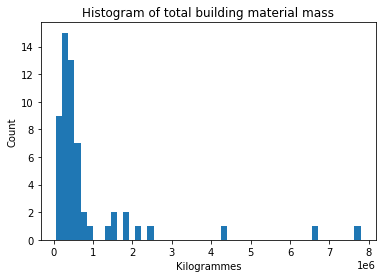

In [10]:
plt.hist(df[[c for c in df.columns if 'kg' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material mass')
plt.xlabel('Kilogrammes')
plt.ylabel('Count');

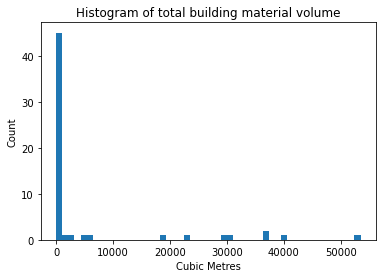

In [11]:
plt.hist(df[[c for c in df.columns if 'm3' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material volume')
plt.xlabel('Cubic Metres')
plt.ylabel('Count');

# 2. Investigate a specific material

In this example, we use the helper function `get_material_name()` to select columns which match `steel`. Then, we calculate the average amount of steel used by floor, produce a table of values by Level 3 MasterFormat only, and calculate the average values for these by year in the dataset.

In [12]:
material = 'steel'
cols = []
for column in df.columns[7:]: #Iterate through columns that represent materials
    if get_material_name(column) == 'steel' and 'kg' in column: #If that column represents steel and is a mass value:
        cols.append(column) #Append to cols

In [13]:
steel_df = df[df.columns[1:7].to_list() + cols].fillna(0) #Select only the heading columns and the columns related to steel

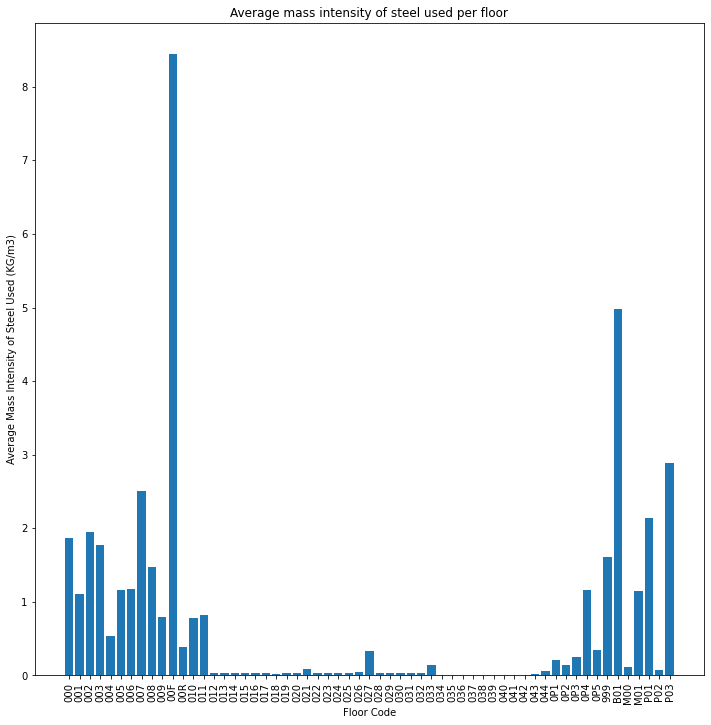

In [14]:
grouping_function = lambda x: x.split('_')[0] #This function takes in a full column name, like "000_G2010.20.000_03 00 00.00_m3_1", and returns only the floor.
to_draw = steel_df[cols].groupby(grouping_function,axis=1).sum().replace(0,np.NaN).div(df['Gross Floor Area'],axis='rows').mean()
plt.figure(figsize=(12,12))
plt.bar(to_draw.keys(), to_draw.values)
plt.xticks(rotation=90)
plt.title('Average mass intensity of steel used per floor')
plt.ylabel('Average Mass Intensity of Steel Used (KG/m3)')
plt.xlabel('Floor Code');

Now, we will aggregate to Level 3 MasterFormat codes, and display these values for the first three entries.

In [57]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1]] #This function takes in a full column name and returns only the Level 3 MasterFormat code.
steel_general_df = steel_df[cols].groupby(f,axis=1).sum()

In [59]:
steel_general_df.mean().sort_values(ascending=False)

Special Foundations           37173.397268
Floor Construction            28865.095665
Standard Slabs-on-Grade       10342.306051
Standard Foundations          10227.105924
Stairs                        10200.914138
Exterior Louvers and Vents     3133.442667
Roof Construction              2590.374290
Interior Specialties            642.577813
Vertical Conveying Systems      534.019170
Exterior Walls                  458.103116
Roadways                        198.354351
Site Development                185.742018
Horizontal Openings              94.650632
Structural Slabs-on-Grade        78.208032
Pits and Bases                   66.594944
Exterior Doors and Grilles       55.660807
Interior Doors                   24.265263
Building Subdrainage             18.938837
Roofing                          11.524558
dtype: float64

## Pie chart version A: on-pie chart labels for all > 1%

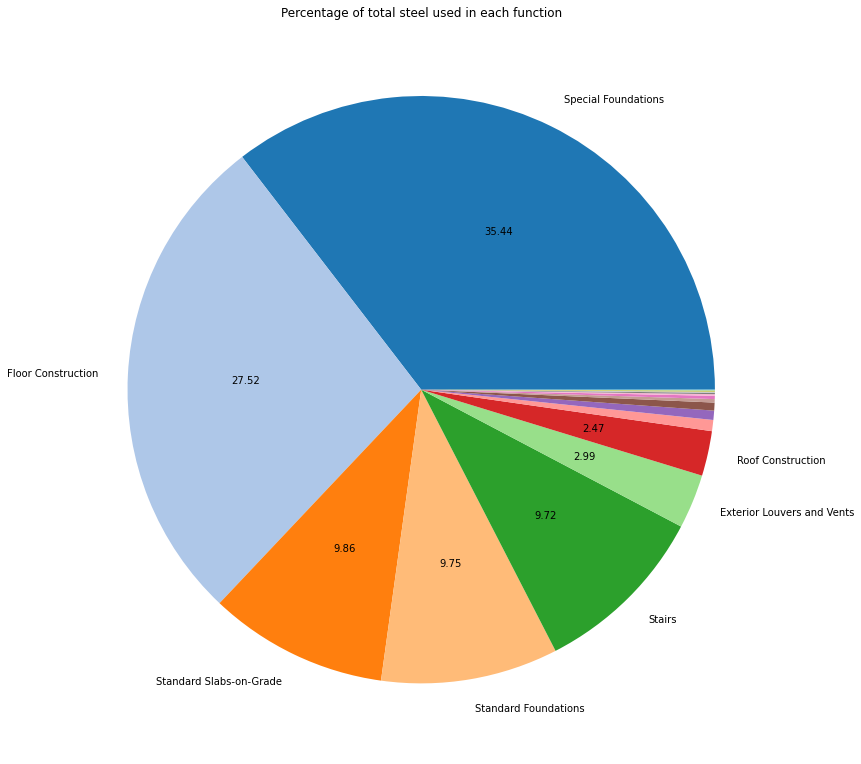

In [73]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df.mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labels=[k if v > 1000 else '' for k,v in to_plot.items()])
plt.ylabel('')
plt.title('Percentage of total steel used in each function');
# plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

## Pie version B: external legend with slice labels

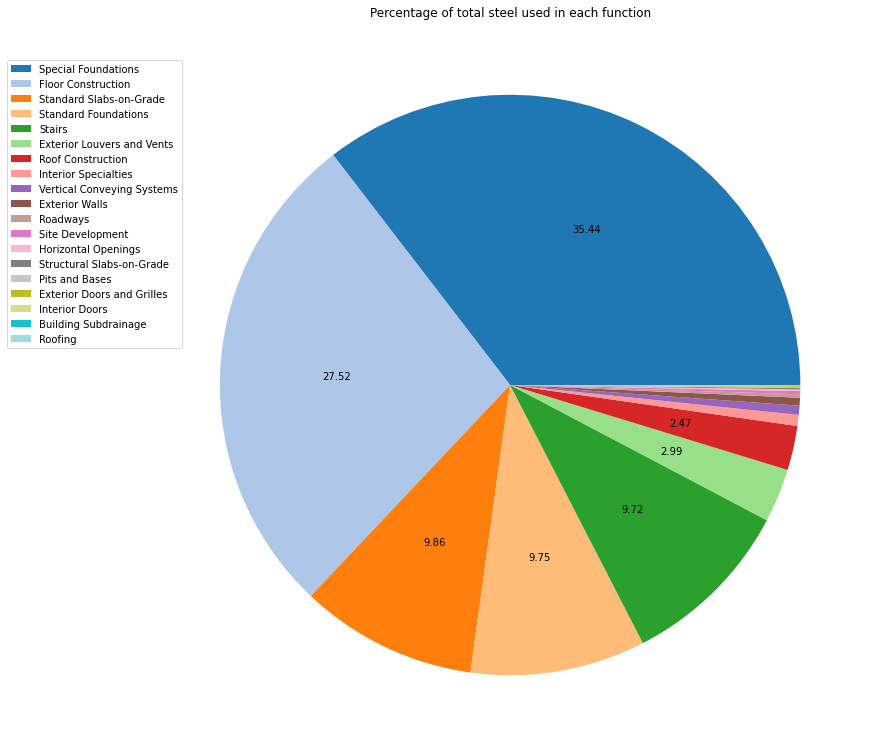

In [74]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df.mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labeldistance=None)
plt.ylabel('')
plt.title('Percentage of total steel used in each function');
plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

We can produce a pie chart for a single building, also.

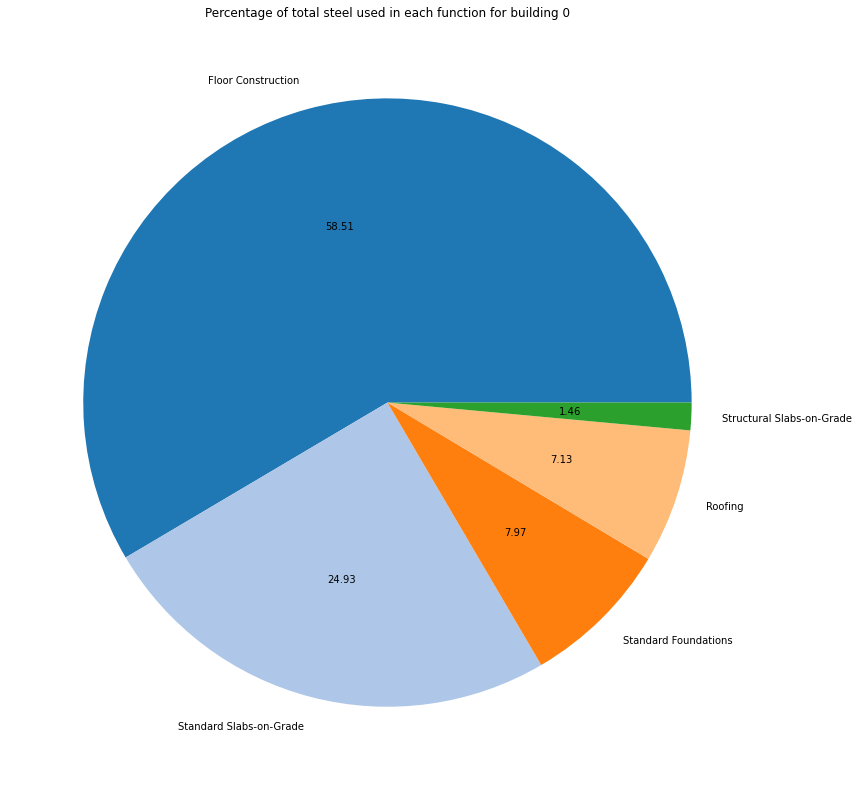

In [81]:
BUILDING_ID = 0

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df.loc[BUILDING_ID,:].sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct)
plt.ylabel('')
plt.title(f'Percentage of total steel used in each function for building {BUILDING_ID}');
plt.tight_layout();



Or an entire class of building:

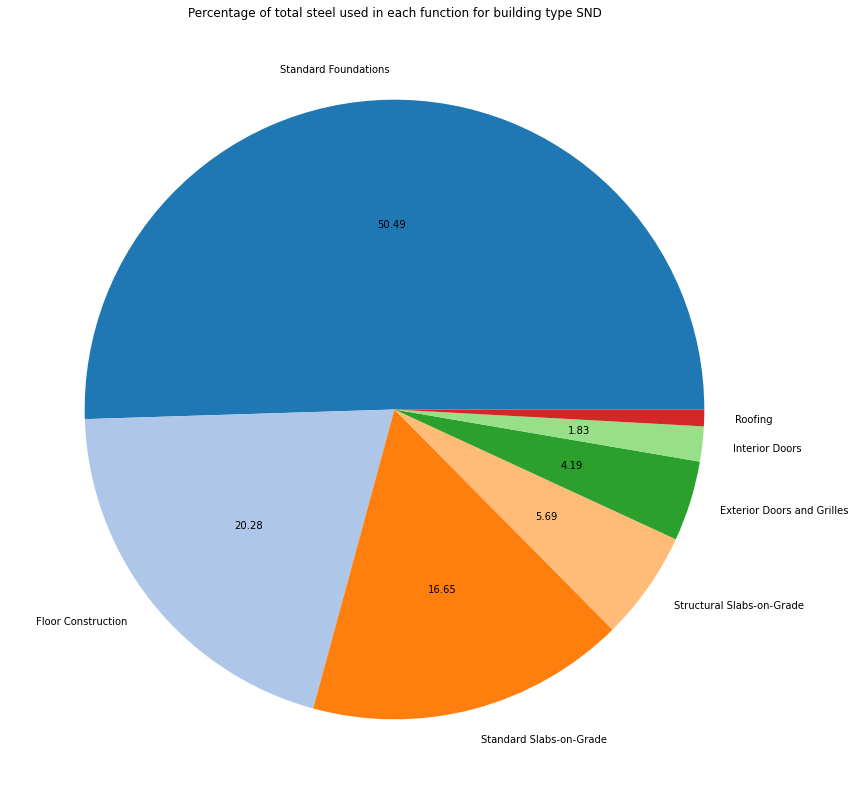

In [93]:
steel_general_df = pd.concat([steel_df['Building Type'],steel_df[cols].groupby(f,axis=1).sum()],axis=1)
BUILDING_TYPE = 'SND'

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df[steel_general_df['Building Type'] == BUILDING_TYPE][steel_general_df.columns[1:]].mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct)
plt.ylabel('')
plt.title(f'Percentage of total steel used in each function for building type {BUILDING_TYPE}');
plt.tight_layout();


We can also calculate the average for each Level 3 MasterFormat code by year of construction:

In [95]:
steel_general_df = pd.concat([steel_df[headings[1:]],steel_df[cols].groupby(f,axis=1).sum()],axis=1)
steel_general_df.groupby('Construction Date').mean()

,Gross Floor Area,Building Subdrainage,Exterior Doors and Grilles,Exterior Louvers and Vents,Exterior Walls,Floor Construction,Horizontal Openings,Interior Doors,Interior Specialties,Pits and Bases,Roadways,Roof Construction,Roofing,Site Development,Special Foundations,Stairs,Standard Foundations,Standard Slabs-on-Grade,Structural Slabs-on-Grade,Vertical Conveying Systems
Construction Date,,,,,,,,,,,,,,,,,,,,
1913,161.080000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,96.325400,0.000000,0.000000
1917,199.930000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,20.818800,0.000000
1969,373.605000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,98.436400,0.000000
1988,21934.000000,0.000000,0.000000,0.000,10078.408608,1495.478593,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,12489.757893,134033.498513,54829.743735,0.000000,668.292683
2007,73600.000000,0.000000,0.000000,0.000,0.000000,65657.800000,0.000,0.000000,33330.000000,0.000000,0.0000,4498.000000,0.000000,0.000000,244138.1400,181050.202000,0.000000,150141.926000,0.000000,15851.600000
2009,73083.000000,0.000000,0.000000,177182.000,2125.780000,155524.200000,0.000,0.000000,0.000000,0.000000,7047.2590,127481.444506,0.000000,0.000000,0.0000,0.000000,202831.440000,128379.999000,0.000000,13919.200000
2011,11282.500000,0.000000,0.000000,0.000,3010.789500,187074.843350,0.000,0.000000,0.000000,360.315000,2129.4695,0.000000,0.000000,3397.480000,22038.8750,4797.606000,20097.177500,38548.367000,0.000000,0.000000
2016,30345.000000,0.000000,0.000000,0.000,0.000000,25017.117500,0.000,0.000000,0.000000,517.236500,0.0000,0.000000,0.000000,0.000000,256540.0660,27694.486000,7123.286250,28069.480500,0.000000,0.000000
2017,39392.013333,0.000000,0.000000,0.000,2267.603333,293693.269133,0.000,0.000000,0.000000,680.269612,0.0000,2272.634333,0.000000,1264.111667,210904.2151,29604.705000,21271.223747,30701.309915,0.000000,0.000000


We can get the average amount of steel in KG used per building type:

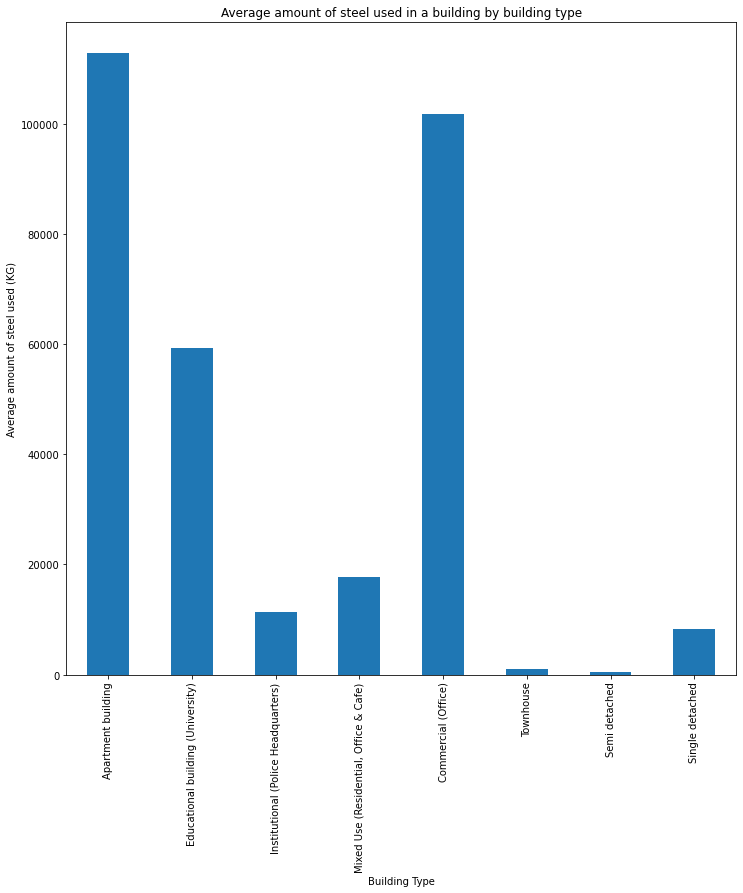

In [96]:
steel_general_df.groupby('Building Type').sum().mean(axis=1).rename(index=building_name_map).plot(kind='bar',figsize=(12,12))
plt.ylabel('Average amount of steel used (KG)')
plt.title('Average amount of steel used in a building by building type');

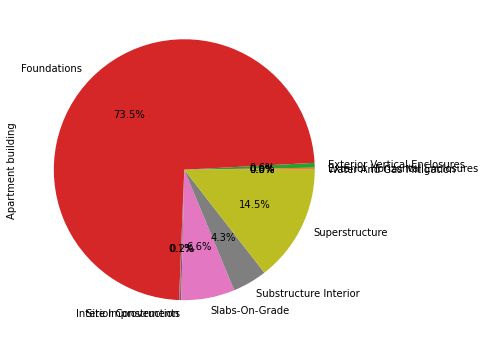

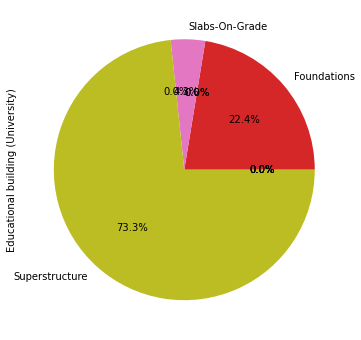

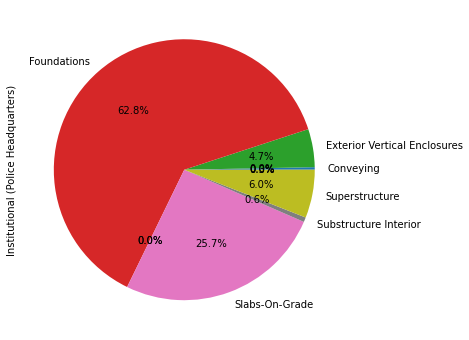

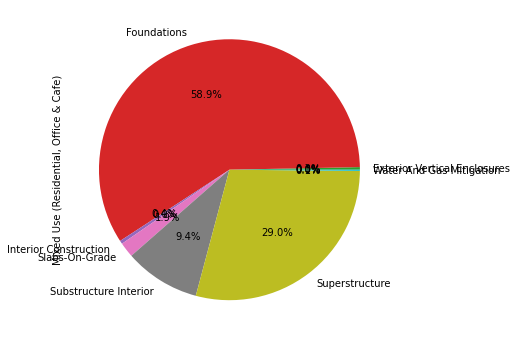

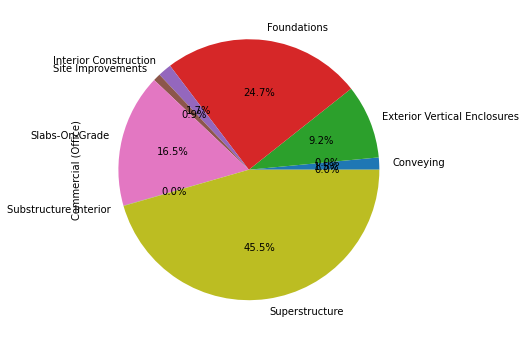

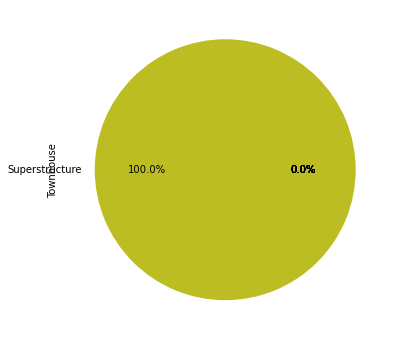

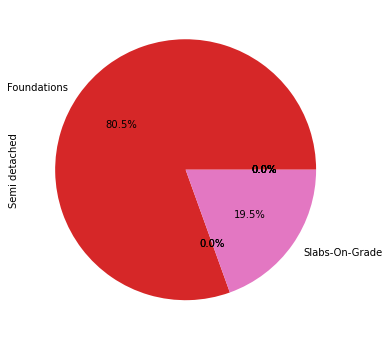

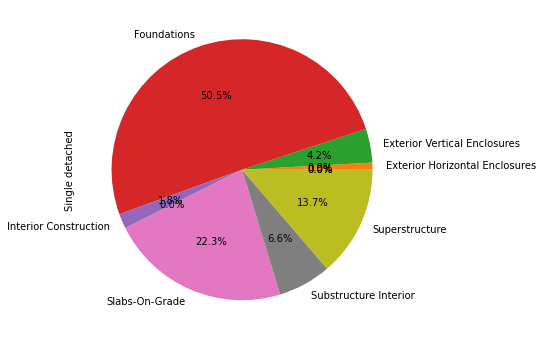

In [97]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]] #From a full code, return only the use code and uncertainty code.
tdf = pd.concat([df['Building Type'],df[cols].groupby(f,axis=1).sum()],axis=1).groupby('Building Type').mean().rename(index=building_name_map).transpose()
for i,k in enumerate(tdf.columns.values):
    tdf.plot.pie(y=k,figsize=(6,6),autopct='%1.1f%%',legend=False);

# 3. Uncertainty by Building Type

In this section, we look at the uncertainty code associated with each column. We collect these by building type and then report the number of each value per type of building.

In [98]:
uncertainty_level = {} 
for k,v in df.iterrows():
    #Initialise empty lists for each building type as they occur
    if v['Building Type'] not in uncertainty_level.keys():
        uncertainty_level[v['Building Type']] = []
    #Append the uncertainty value for each column that is non-NaN
    for key in v[~v.isna()].keys()[7:]:
        uncertainty_level[v['Building Type']].append(key.split('_')[-1])

In [99]:
from collections import Counter

In [100]:
for k,v in uncertainty_level.items():
    uncertainty_level[k] = Counter(v) #Construct a Counter object per building type

In [101]:
uncertainty_level

{'SND': Counter({'1': 1812,
          '2': 731,
          '4': 357,
          '1.1': 1088,
          '4.1': 204,
          '2.1': 314}),
 'OFF': Counter({'1': 494, '3': 307, '1.1': 109, '3.1': 307}),
 'APB': Counter({'1': 1167, '2': 1, '3': 985, '1.1': 298, '3.1': 312}),
 'SMD': Counter({'1': 204, '2': 61, '4': 27, '1.1': 107, '2.1': 9, '4.1': 10}),
 'EDU': Counter({'1': 93, '3': 24, '1.1': 38, '3.1': 24, '2': 6}),
 'INS': Counter({'1': 90, '3': 77, '2': 1, '1.1': 90, '3.1': 77, '2.1': 1}),
 'ROW': Counter({'1': 15, '3': 5, '1.1': 14, '3.1': 5}),
 'MIX': Counter({'1': 364, '3': 276, '1.1': 287})}

Next, we aggregate columns by use code and uncertainty combined, and report the average by building type.

In [102]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + x.split('_')[-1].split('.')[0] #From a full code, return only the use code and uncertainty code.
by_function_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)

In [103]:
by_function_df.groupby('Building Type').mean().rename(index=building_name_map)

,Construction Date,Gross Floor Area,Interiors/1,Interiors/2,Services/1,Shell/1,Shell/2,Shell/3,Shell/4,Sitework/1,Sitework/3,Substructure/1,Substructure/2,Substructure/3,Substructure/4
Building Type,,,,,,,,,,,,,,,
Apartment building,2015.80,45113.208000,384.216909,0.000,0.000000,5857.618000,0.0000,59399.537000,0.000000,225.295,533.172000,233723.508400,0.000000,126579.210600,0.00000
Educational building (University),2016.50,7901.000000,0.000000,0.000,0.000000,442895.163700,0.0000,7081.563500,0.000000,0.000,0.000000,0.000000,0.000000,163680.896810,0.00000
Institutional (Police Headquarters),1988.00,21934.000000,0.000000,0.000,668.292683,259.573171,0.0000,22568.166501,0.000000,0.000,0.000000,0.000000,0.000000,190099.147671,0.00000
"Mixed Use (Residential, Office & Cafe)",2018.00,33975.250000,1375.850817,0.000,0.000000,4477.775000,0.0000,94212.560000,0.000000,0.000,0.000000,151968.510000,0.000000,84478.698683,0.00000
Commercial (Office),2009.00,52643.666667,11110.000000,0.000,9923.600000,298456.310402,0.0000,61618.104000,0.000000,0.000,6033.719333,0.000000,0.000000,271356.078667,0.00000
Townhouse,2018.00,1961.020000,0.000000,0.000,0.000000,14039.200000,0.0000,2393.622000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00000
Semi detached,1994.75,236.615000,0.000000,0.000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,165.306500,11.036450,0.000000,8.49255
Single detached,2015.60,465.227000,0.000000,34.578,0.000000,230.925800,110.9122,0.000000,13.373145,0.000,0.000000,1352.047125,111.740235,0.000000,40.68581


Next, we report the total amount of material falling under each uncertainty code by year of construction.

In [104]:
f = lambda x: x.split('_')[-1].split('.')[0] #Select only the uncertainty code.
pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1).groupby('Construction Date').mean()

,Gross Floor Area,1,2,3,4
Construction Date,,,,,
1913,161.080000,96.325400,0.000000,0.000000,0.000000
1917,199.930000,0.000000,20.818800,0.000000,0.000000
1969,373.605000,0.000000,98.436400,0.000000,0.000000
1988,21934.000000,927.865854,0.000000,212667.314172,0.000000
2007,73600.000000,119337.400000,0.000000,575330.268000,0.000000
2009,73083.000000,474106.844506,0.000000,340384.478000,0.000000
2011,11282.500000,187029.863350,0.000000,94425.059500,0.000000
2016,30345.000000,141518.600000,0.000000,203443.072750,0.000000
2017,39392.013333,458663.635133,0.000000,133995.706707,0.000000


# 4. Material Intensity

We can easily calculate material intensity by dividing columns which are measured in kilograms by the `Gross Floor Area`:

In [105]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

In [106]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]]
pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1)[df['Building Type'] == 'SND']

,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,Conveying,Exterior Horizontal Enclosures,Exterior Vertical Enclosures,Foundations,...,Interior Finishes,Plumbing,Site Improvements,Slabs-On-Grade,Special Construction,Subgrade Enclosures,Substructure Interior,Substructure Related Activities,Superstructure,Water And Gas Mitigation
0,CA,TOR,00IFC,2021,SND,521.18,0.0,14.393646,147.811220,353.958084,...,16.618827,0.0,0.0,323.952856,0.0,14.438812,0.000000,0.0,54.998131,0.0
1,CA,TOR,00IFC,2021,SND,389.24,0.0,5.461939,133.423435,281.318698,...,6.490936,0.0,0.0,194.232091,0.0,13.374339,0.000000,0.0,36.739564,0.0
2,CA,TOR,00IFC,2021,SND,411.64,0.0,3.955589,182.905692,465.097017,...,9.149811,0.0,0.0,218.629213,0.0,19.208236,0.000000,0.0,43.752969,0.0
3,CA,TOR,00IFC,2021,SND,269.56,0.0,6.503479,370.711117,258.361801,...,8.510443,0.0,0.0,128.098456,0.0,6.543260,0.000000,0.0,57.294905,0.0
6,CA,TOR,00IFC,2021,SND,445.99,0.0,11.934602,114.888632,301.393384,...,12.782125,0.0,0.0,179.786278,0.0,16.469983,0.108904,0.0,63.871222,0.0
7,CA,TOR,00IFC,2021,SND,438.45,0.0,19.770004,255.228896,270.947699,...,6.584780,0.0,0.0,277.432676,0.0,7.767302,0.000000,0.0,64.247009,0.0
8,CA,TOR,00IFC,2021,SND,714.07,0.0,19.930097,206.174209,276.917123,...,13.127789,0.0,0.0,317.786761,0.0,15.274836,0.000000,0.0,63.916950,0.0
9,CA,TOR,00IFC,2021,SND,343.24,0.0,8.589688,251.349228,285.386581,...,11.076655,0.0,0.0,141.281528,0.0,16.513088,0.000000,0.0,57.151395,0.0
12,CA,TOR,00IFC,2021,SND,226.89,0.0,17.701736,233.301466,265.332998,...,6.134611,0.0,0.0,136.637311,0.0,5.559963,1.871224,0.0,57.861266,0.0
13,CA,TOR,00IFC,2021,SND,611.73,0.0,5.196340,186.629283,344.014507,...,7.638991,0.0,0.0,211.850660,0.0,10.923807,0.000000,0.0,62.638873,0.0
